In [174]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

import statistics

BATCH_SIZE = 64

In [175]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# **ImageNet**

In [176]:
x_train = np.load('./dataset/x_train_imagenet_unlearn.npy')
y_train = np.load('./dataset/y_train_imagenet.npy')
x_val = np.load('./dataset/x_val_imagenet.npy')
y_val = np.load('./dataset/y_val_imagenet.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [177]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

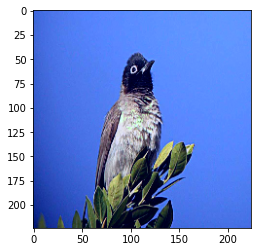

In [178]:
plt.imshow(x_train[4],cmap='gray')

In [179]:
up_down_flip_p = 0.4
left_right_flip_p = 0.4

noise_p = 1
rot_p = 0.5

crop_p = 0.5
brightness_p = 0.6
saturation_p = 0.6
contrast_p = 0.6

In [180]:
@tf.function
def gaussian_noise(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < noise_p:
        noise = tf.random.normal(image.shape, stddev=0.01)
        image = tf.math.add(image, noise)
        
    return image

@tf.function
def random_flip(image):
    up_down_outcome = tf.random.uniform([1], 0, 1)
    right_left_outcome = tf.random.uniform([1], 0, 1)

    if up_down_outcome<up_down_flip_p:
        image = tf.image.flip_up_down(image)

    if right_left_outcome<left_right_flip_p:
        image = tf.image.flip_left_right(image)

    return image

@tf.function
def random_rot90(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < (rot_p/2):
        image = tf.image.rot90(image)
    elif (prob >= (rot_p/2)) and (prob < rot_p):
        image = tf.image.rot90(image, k=2)   
        
    return image

@tf.function
def r_crop(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < crop_p:
        image = tf.image.resize(image, size=[IMAGE_HEIGHT + 5, IMAGE_WIDTH + 5])
        image = tf.image.random_crop(image, size=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    else:
        image = tf.image.resize(image, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
        
    return image

@tf.function
def brightness(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < brightness_p:
        image = tf.image.random_brightness(image, 0.5)
        
    return image

@tf.function
def saturation(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < saturation_p:
        image = tf.image.random_saturation(image, 0.85, 1.5)
        
    return image

@tf.function
def contrast(image):
    prob = tf.random.uniform([1], 0, 1)
    
    if prob < contrast_p:
        image = tf.image.random_contrast(image, 0.9, 2)
        
    return image

In [183]:
def data_preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    image = contrast(image)
    image = brightness(image)
    image = saturation(image)
    
#    image = random_flip(image)
#    image = random_rot90(image)
    image = gaussian_noise(image)
#    image = tf.keras.applications.densenet.preprocess_input(image)

    return image, label

class dataset_generator():
    
    def __init__(self, image_path, label_path, batch_size):
        self.batch_size = batch_size
        
        image = np.load(image_path)
        gaussian = np.random.normal(0, 0.0001, (224, 224, 3)) 
        image = np.array([img + gaussian for img in image])
        self.image = image
        
        label = np.load(label_path)
        label = np.argmax(label, axis=1)
        self.label = label
        
    def generate(self, generate_func):
        dataset = tf.data.Dataset.from_tensor_slices((self.image, self.label))
        dataset = dataset.map(generate_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(1000)
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

In [184]:
x_train_path = './dataset/x_train_imagenet_unlearn.npy'
y_train_path = './dataset/y_train_imagenet.npy'
BATCH_SIZE = 64

ds_generator = dataset_generator(x_train_path, y_train_path, BATCH_SIZE)

dataset = ds_generator.generate(data_preprocess)

In [319]:
#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())
                
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())
                
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [320]:
optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 如果以上 work 可能要把 原本的acc 改成 accuracy
checkpoint_filepath = './tmp_imagenet/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.fit(dataset, validation_data=batched_val_dataset, epochs=100, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/100
34/34 [==============================] - 4s 64ms/step - loss: 0.4535 - accuracy: 0.8929 - val_loss: 1.6861 - val_accuracy: 0.4062
Epoch 2/100
34/34 [==============================] - 3s 59ms/step - loss: 0.1967 - accuracy: 0.9600 - val_loss: 2.6390 - val_accuracy: 0.4062
Epoch 3/100
34/34 [==============================] - 3s 58ms/step - loss: 0.1654 - accuracy: 0.9550 - val_loss: 5.0153 - val_accuracy: 0.4062
Epoch 4/100
34/34 [==============================] - 3s 59ms/step - loss: 0.1417 - accuracy: 0.9591 - val_loss: 5.5285 - val_accuracy: 0.4062
Epoch 5/100
34/34 [==============================] - 3s 60ms/step - loss: 0.0861 - accuracy: 0.9775 - val_loss: 6.1614 - val_accuracy: 0.4062
Epoch 6/100
34/34 [==============================] - 3s 59ms/step - loss: 0.0984 - accuracy: 0.9715 - val_loss: 5.1296 - val_accuracy: 0.4062
Epoch 7/100
34/34 [==============================] - 3s 59ms/step - loss: 0.0664 - accuracy: 0.9802 - val_loss: 4.2885 - val_accuracy: 0.4062
Epoch 

In [321]:
x_test = np.load('./dataset/x_test_imagenet.npy')
model.load_weights(checkpoint_filepath)
y_test = model.predict(x_test)

In [322]:
output = {
    'id': np.arange(len(x_test)),
    'label': np.array([1 if (x>0.5) else 0 for x in y_test])
}
y__test_pred = pd.DataFrame(data=output)
y__test_pred.to_csv('submission_imagenet_origin.csv', index=False)

In [296]:
y__test_pred1 = pd.read_csv('./submission_imagenet_origin.csv')
y__test_pred2 = pd.read_csv('./submission_imagenet_bf.csv')
y__test_pred3 = pd.read_csv('./submission_imagenet_gb.csv')

response=[]

for i in range(y__test_pred1.shape[0]):
    
    most = statistics.mode([y__test_pred1['label'][i], 
                           y__test_pred2['label'][i], 
                           y__test_pred3['label'][i]])
    response.append(most)

In [ ]:
output_ensemble = {
    'id': np.arange(len(x_test)),
    'label': np.array([x for x in response])
    }

y__test_pred_ensemble = pd.DataFrame(data=output_ensemble)
y__test_pred_ensemble.to_csv('submission_ensemble_imagenet.csv', index=False)

# **CIFAR-10**

In [67]:
x_train = np.load('./dataset/x_train_cifar10_unlearn.npy')
y_train = np.load('./dataset/y_train_cifar10.npy')
x_val = np.load('./dataset/x_val_cifar10.npy')
y_val = np.load('./dataset/y_val_cifar10.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [70]:
#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [74]:
def data_preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    image = contrast(image)
    image = brightness(image)
    image = saturation(image)
    
#    image = random_flip(image)
#    image = random_rot90(image)
#    image = gaussian_noise(image)
#    image = tf.keras.applications.densenet.preprocess_input(image)

    return image, label

class dataset_generator():
    
    def __init__(self, image_path, label_path, batch_size):
        self.batch_size = batch_size
        
        image = np.load(image_path)
        gaussian = np.random.normal(0, 0.00001, (32, 32, 3)) 
        image = np.array([img + gaussian for img in image])
        self.image = image
        
        label = np.load(label_path)
        label = np.argmax(label, axis=1)
        self.label = label
        
    def generate(self, generate_func):
        dataset = tf.data.Dataset.from_tensor_slices((self.image, self.label))
        dataset = dataset.map(generate_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(1000)
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

In [75]:
x_train_path = './dataset/x_train_cifar10_unlearn.npy'
y_train_path = './dataset/y_train_cifar10.npy'
BATCH_SIZE = 64

ds_generator = dataset_generator(x_train_path, y_train_path, BATCH_SIZE)

dataset = ds_generator.generate(data_preprocess)

In [76]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# 載入keras模型(更換輸出圖片尺寸)
model = DenseNet201(include_top=False,
                 weights='imagenet',
                 input_tensor=Input(shape=(32, 32, 3))
                 )

# 定義輸出層
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)


#model.summary()

In [77]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [1]:
checkpoint_filepath = './tmp_cifar/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
    
history = model.fit(x=dataset, validation_data=batched_val_dataset, epochs=500, callbacks=[model_checkpoint_callback])

In [79]:
model.load_weights(checkpoint_filepath)

In [80]:
x_test = np.load('./dataset/x_test_cifar10.npy')
y_test = model.predict(x_test)

In [81]:
output = {
    'id': np.arange(len(x_test)),
    'label': np.array([np.argmax(x) for x in y_test])
}
y__test_pred = pd.DataFrame(data=output)
y__test_pred.to_csv('submission_densenet.csv', index=False)

In [94]:
y__test_pred1 = pd.read_csv('./submission_cifar_origin.csv')
y__test_pred2 = pd.read_csv('./submission_cifar_origin2.csv')
y__test_pred3 = pd.read_csv('./submission_cifar_origin3.csv')

response=[]

for i in range(y__test_pred1.shape[0]):
    
    most = statistics.mode([y__test_pred1['label'][i], 
                           y__test_pred2['label'][i], 
                           y__test_pred3['label'][i]])
    response.append(most)

In [96]:
output_ensemble = {
    'id': np.arange(len(x_test)),
    'label': np.array([x for x in response])
    }

y__test_pred_ensemble = pd.DataFrame(data=output_ensemble)
y__test_pred_ensemble.to_csv('submission_ensemble_imagenet.csv', index=False)